In [116]:
import torch
import tqdm
import numpy as np
import json
import glob
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import uuid
import collections
from typing import List
from fvcore.common.file_io import PathManager
from PIL import Image, ImageOps
import pickle
print(f'torch version : {torch.__version__}')

torch version : 1.4.0


In [113]:
root_dir='/opt/gitserial/tianchi'
data_paths=sorted(glob.glob(os.path.join(root_dir,'data/')+'train_dataset_part?'))
image_paths=[]
video_paths=[]
video_annotation_paths=[]
image_key_dict=collections.OrderedDict()
video_key_dict=collections.OrderedDict()
cache_file='/opt/gitserial/tianchi/cache/image_annotation.pkl'
for x in data_paths:
    image_paths.extend(glob.glob(x+'/image/*/*.jpg'))
    video_paths.extend(glob.glob(x+'/video/*.mp4'))
    video_annotation_paths.extend(glob.glob(x+'/video_annotation/*.json'))
print(f'the total len pics is :{len(image_paths)},{image_paths[888]}')
print(f'the total len video is :{len(video_paths)},{video_paths[888]}')
print(f'the total len video_annotation_paths is :{len(video_annotation_paths)},{video_annotation_paths[888]}')
#%tree -d -L 2


the total len pics is :150243,/opt/gitserial/tianchi/data/train_dataset_part1/image/047867/5.jpg
the total len video is :30000,/opt/gitserial/tianchi/data/train_dataset_part1/video/112483.mp4
the total len video_annotation_paths is :30000,/opt/gitserial/tianchi/data/train_dataset_part1/video_annotation/038333.json


In [16]:
categories = []

CLASS_DICT = collections.OrderedDict({
'短外套':1,
'古风':2, '古装':2,
'短裤':3,
'短袖上衣':4,
'长半身裙':5,
'背带裤':6,
'长袖上衣':7,
'长袖连衣裙':8,
'短马甲':9,
'短裙':10,
'背心上衣':11,
'短袖连衣裙':12,
'长袖衬衫':13,
'中等半身裙':14,
'无袖上衣':15,
'长外套':16,
'无袖连衣裙':17,
'连体衣':18,
'长马甲':19,
'长裤':20,
'吊带上衣':21,
'中裤':22,
'短袖衬衫':23})
for k in list(CLASS_DICT.keys()):
    categories.append({"id": CLASS_DICT[k], "name":k})
    
print(categories)

[{'id': 1, 'name': '短外套'}, {'id': 2, 'name': '古风'}, {'id': 2, 'name': '古装'}, {'id': 3, 'name': '短裤'}, {'id': 4, 'name': '短袖上衣'}, {'id': 5, 'name': '长半身裙'}, {'id': 6, 'name': '背带裤'}, {'id': 7, 'name': '长袖上衣'}, {'id': 8, 'name': '长袖连衣裙'}, {'id': 9, 'name': '短马甲'}, {'id': 10, 'name': '短裙'}, {'id': 11, 'name': '背心上衣'}, {'id': 12, 'name': '短袖连衣裙'}, {'id': 13, 'name': '长袖衬衫'}, {'id': 14, 'name': '中等半身裙'}, {'id': 15, 'name': '无袖上衣'}, {'id': 16, 'name': '长外套'}, {'id': 17, 'name': '无袖连衣裙'}, {'id': 18, 'name': '连体衣'}, {'id': 19, 'name': '长马甲'}, {'id': 20, 'name': '长裤'}, {'id': 21, 'name': '吊带上衣'}, {'id': 22, 'name': '中裤'}, {'id': 23, 'name': '短袖衬衫'}]


150243,/opt/gitserial/tianchi/data/train_dataset_part1/image/071118/4.jpg
/opt/gitserial/tianchi/data/train_dataset_part2/image/031093
0.json  1.json  2.json  3.json  4.json  5.json


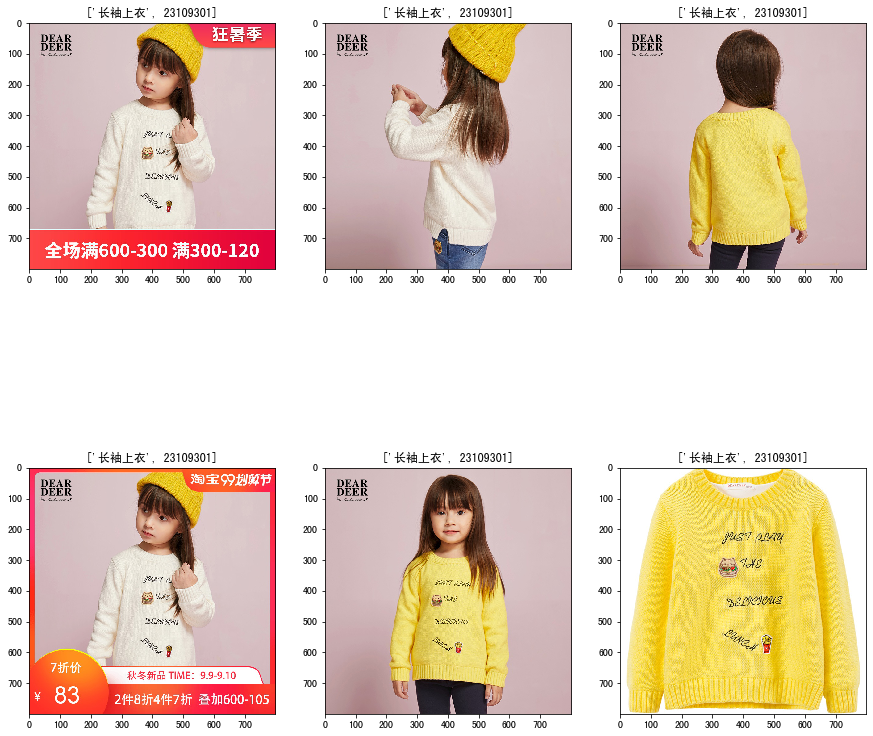

In [103]:
print(f'{len(image_paths)},{image_paths[88]}')
seed=random.randint(0,len(image_paths)-1)
dev_path='/'.join(image_paths[seed].split('/')[:-1])
print(dev_path)
%ls /data/datasets/ali_tianchi/train_dataset_part1/image_annotation/020169
'''
{'item_id': '001114',
 'annotations': [{'display': 1,
   'box': [200, 216, 636, 691],
   'viewpoint': 0,
   'instance_id': 20111401,
   'label': '长袖上衣'}],
 'img_name': '5.jpg'}
'''
plt.figure(figsize=(15,15)) 
# Blue color in BGR 
color = (0, 0, 255) 
  
# Line thickness of 2 px 
thickness = 5
for i in range(len(os.listdir(dev_path))):
    plt.subplot(2, 3, i+1)
    with open(os.path.join(dev_path,'..','..','image_annotation',dev_path.split('/')[-1],f'{i}.json')) as f:
        for line in f.readlines():
            o=json.loads(line)
            box_points=o['annotations'][0]['box']
#             print(o['annotations'][0]['label'])
        img=cv2.imread(os.path.join(dev_path,'..','..','image',dev_path.split('/')[-1],f'{i}.jpg'),cv2.IMREAD_COLOR)[:,:,::-1]
#         img=read_image(os.path.join(dev_path,'..','..','image',dev_path.split('/')[-1],f'{i}.jpg'))
        cv2.rectangle(img[:,:,::-1], (box_points[0],box_points[1]),(box_points[2],box_points[3]), color, thickness)
        plt.title([o['annotations'][0]['label'],o['annotations'][0]['instance_id']])
        plt.imshow(img)
plt.show()

In [129]:
def gen_image_dicts(data_path='/opt/gitserial/tianchi/data',outout_path='/opt/gitserial/tianchi/data'):
    global data_paths,image_key_dict,video_key_dict,image_paths
    def read_image(file_name, format=None):
        """
        Read an image into the given format.
        Will apply rotation and flipping if the image has such exif information.

        Args:
            file_name (str): image file path
            format (str): one of the supported image modes in PIL, or "BGR"

        Returns:
            image (np.ndarray): an HWC image in the given format.
        """
        with PathManager.open(file_name, "rb") as f:
            image = Image.open(f)

            # capture and ignore this bug: https://github.com/python-pillow/Pillow/issues/3973
            try:
                image = ImageOps.exif_transpose(image)
            except Exception:
                pass

            if format is not None:
                # PIL only supports RGB, so convert to RGB and flip channels over below
                conversion_format = format
                if format == "BGR":
                    conversion_format = "RGB"
                image = image.convert(conversion_format)
            image = np.asarray(image)
            if format == "BGR":
                # flip channels if needed
                image = image[:, :, ::-1]
            # PIL squeezes out the channel dimension for "L", so make it HWC
            if format == "L":
                image = np.expand_dims(image, -1)
            return image
    
    image_key_dict={os.path.basename(os.path.dirname(i)):[] for i in image_paths}
    try:
        with tqdm.tqdm(image_paths) as t:
            for i,image_path in enumerate(t):
                pp_key=os.path.basename(os.path.dirname(image_path))
                img = read_image(image_path)
                ann = json.load(open(image_path.replace('image', 'image_annotation').replace('jpg', 'json') ,'r'))
                k=ann['annotations'][0]['label']
                items=image_key_dict[pp_key]
                new_item_dict={
                    'file_name':image_path,
                    'height':int(img.shape[0]),
                    'width':int(img.shape[1]),
                    'annotation':ann,
                    'categories':{"id": CLASS_DICT[k], "name":k}
                }
                items.append(new_item_dict)
                image_key_dict[pp_key]=items
    except KeyboardInterrupt:
        t.close()
        raise
    t.close()



In [130]:
image_key_dict.clear()       
gen_image_dicts()
print(len(image_key_dict.keys()))

100%|██████████| 150243/150243 [19:14<00:00, 130.09it/s]

30000


In [133]:
# image_key_dict.clear()
# image_key_dict.keys()
with open(cache_file, 'wb') as fid:
    import copy
    a=copy.deepcopy(image_key_dict)
    pickle.dump(a, fid, pickle.HIGHEST_PROTOCOL)
    print(f'wrote key to {cache_file},len of keys is:{len(a.keys())}')

wrote key to /opt/gitserial/tianchi/cache/image_annotation.pkl,len of keys is:30000


In [178]:
def gen_image_dicts(data_path='/opt/gitserial/tianchi/data', outout_path='/opt/gitserial/tianchi/data'):
    global data_paths, video_key_dict, video_paths
    import numpy
    def get_frames(file_name: str, frame_indexes: list) -> List[numpy.ndarray]:
#         print(frame_indexes)
        video = cv2.VideoCapture(file_name)
        ret_list = []
        if frame_indexes:
            for frame in frame_indexes:
                video.set(cv2.CAP_PROP_POS_FRAMES, frame)
                succ, img = video.read()
                if not succ:
                    raise ValueError
                ret_list.append(img)
        return ret_list

    video_key_dict = {os.path.splitext(os.path.basename(i))[0]: [] for i in video_paths}
    try:
        with tqdm.tqdm(video_paths) as t:
            for i, video_path in enumerate(t):
                video_image_dir = os.path.join(os.path.dirname(os.path.dirname(video_path)), 'video_images')
                if not os.path.exists(video_image_dir):
                    os.makedirs(video_image_dir)
                frames = []
                video_ann = json.load(open(video_path.replace('video', 'video_annotation').replace('mp4', 'json'), 'r'))
#                 print(video_ann)
                video_id = video_ann['video_id']
                v_frames_indexes = [video_ann['frames'][x]['frame_index'] for x in range(len(video_ann['frames']))]
#                 print(v_frames_indexes)
                frames.extend(get_frames(video_path, v_frames_indexes))
                vfile_names = []
                anns = []
                categories = []
                for i, img in enumerate(frames):
                    vfile_name = 'v_' + str(video_id) + '_' + str(v_frames_indexes[i]) + '.jpg'
                    succ = cv2.imwrite(os.path.join(video_image_dir, vfile_name), img)
                    if not succ:
                        raise ValueError
                    vfile_names.append(vfile_name)
                    anns.extend(video_ann['frames'][i]['annotations'])
                    k = video_ann['frames'][i]['annotations']
                    for ii in range(len(k)):
                        categories.append({'id': CLASS_DICT[k[ii]['label']], "name": k[ii]['label']})
                # items = video_key_dict[video_id]
                new_item_dict = {
                    'file_name': vfile_names,
                    'annotation': anns,
                    'categories': categories
                }
                # items.append(new_item_dict)
                video_key_dict[video_id] = new_item_dict
#                 if i > 3:
#                     break
    except KeyboardInterrupt:
        t.close()
        raise
    t.close()

In [179]:
gen_image_dicts()

100%|██████████| 30000/30000 [1:48:51<00:00,  4.59it/s]  


In [182]:
cache_video_image='/opt/gitserial/tianchi/cache/video_image_annotation.pkl'
with open(cache_video_image, 'wb') as fid:
    import copy
    a=copy.deepcopy(video_key_dict)
    pickle.dump(a, fid, pickle.HIGHEST_PROTOCOL)
    print(f'wrote key to {cache_video_image},len of keys is:{len(a.keys())}')


wrote key to /opt/gitserial/tianchi/cache/video_image_annotation.pkl,len of keys is:30000
